In [1]:
# this section of project uses triple barrier method of labeling to account for path dependancy

import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from ipynb.fs.full.helpers import SMA, ts_differencing, plot_decision_boundaries, SMA_w_SVCmeta_labeling

In [2]:
#pull in dataset used as the benchmark and dataset for SMA strategy. Note the start and end dates.
#this strategy is likely rendered useless over such a long timeframe but I use this due to the low frequency of data
start = datetime(2002,1,1)
end = datetime(2015,1,1) #(2015,1,1)
stock = data.DataReader("SPY", 'yahoo', start, end).reset_index()
stock.set_index("Date", inplace=True)
close = stock["Close"] #data used for SMA function
vix = data.DataReader("^VIX", 'yahoo', start, end).reset_index()
vix.set_index("Date", inplace=True)
vix = vix["Close"]
length = 5 #of SMA and fractional differencing cutoff
profit_taking = .03
risk_tolerance = .03

In [3]:
growth, daily_val, trades, open_dates, close_dates, SMAlist, untouched = SMA(close, profit_taking, risk_tolerance, length)
print(close[-1]/close[0], growth, len(trades), trades.count(1)/len(trades))

1.7791049550583553 1.3008398567162698 452 0.8053097345132744


In [4]:
df = pd.DataFrame(stock[length:-1])
df["14daySMA"] = SMAlist
df["Daily"] = daily_val[length:-1]
df["untouched"] = untouched[length:-1]

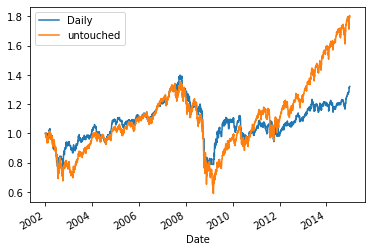

In [5]:
df.iloc[:,-2:].plot()

Feature Assembly

In [6]:
#arbitrarily choose a lag cutoff equal to the SMA length for simplicity
#use fractional differencing to gain stationarity while preserving memory
features = df.iloc[:,4:5]
features["Vix"] = vix 
features[".4diffclose"] = ts_differencing(close,.4,length)
features[".4diffvol"] = ts_differencing(features["Volume"],.4,length)
features[".4diffvix"] = ts_differencing(vix,.4,length)
features.dropna(inplace=True)
tradesdf = pd.DataFrame(trades)
tradesdf.set_index(pd.to_datetime(open_dates[:-1]), inplace=True)
dataset = pd.merge(features,tradesdf, how='inner', left_index=True, right_index=True).rename(columns = {0:"Profitable"})

In [7]:
dataset

,Volume,Vix,.4diffclose,.4diffvol,.4diffvix,Profitable
2002-01-24,12142800.0,21.150000,42.833328,3.955743e+06,7.197920,1
2002-02-01,15838500.0,21.120001,42.159105,1.494762e+06,7.459777,0
2002-02-08,19277800.0,23.260000,42.281358,3.201499e+06,7.421808,1
2002-02-25,17458700.0,21.840000,42.995821,1.138264e+06,7.373472,2
2002-03-05,22718900.0,20.299999,43.672957,5.982210e+06,7.429055,1
...,...,...,...,...,...,...
2014-11-03,93600000.0,14.730000,76.247506,7.675334e+06,5.807376,1
2014-11-11,54499400.0,12.920000,76.768251,6.558210e+06,4.813248,1
2014-11-19,82373000.0,13.960000,76.909936,3.359523e+07,5.311696,1
2014-11-28,57890100.0,13.330000,77.428270,1.339280e+07,5.687680,1


Visualizations

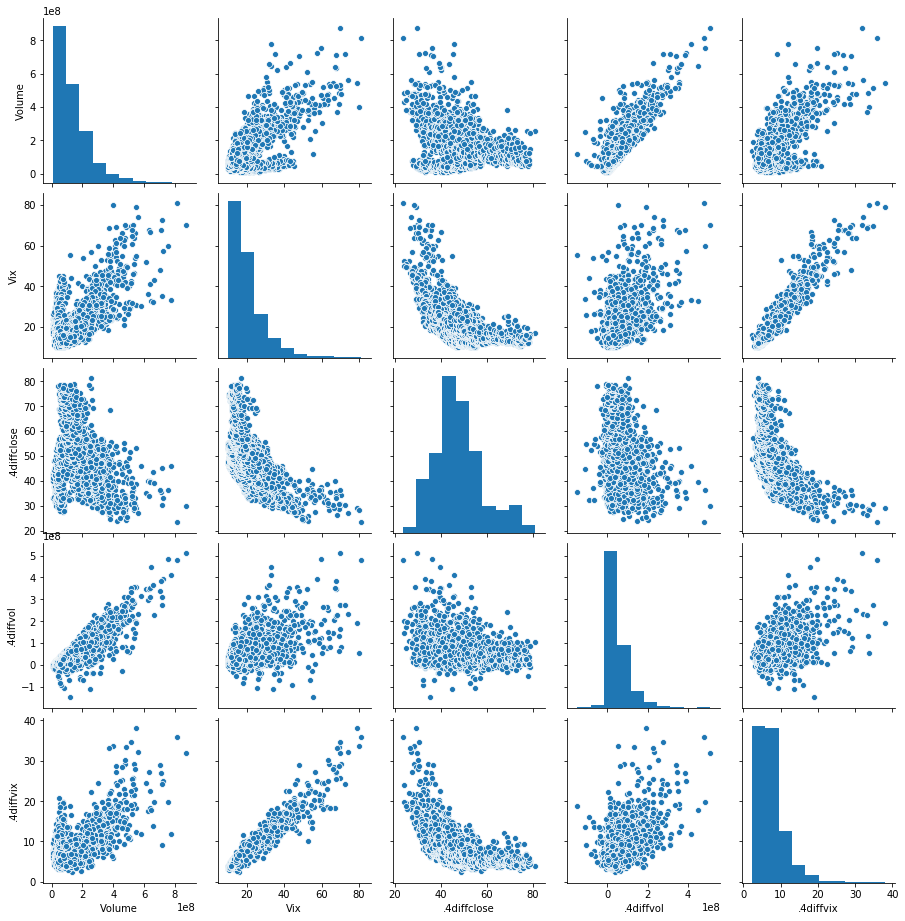

In [8]:
#features.corr()
sns.pairplot(features)
#dataset[".4diffvix"].plot.hist()

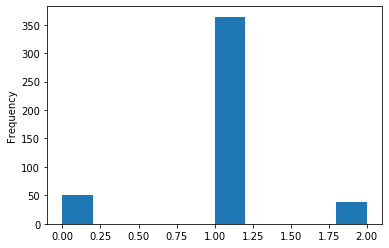

In [9]:
#we are dealing with an unbalanced classes problem
dataset["Profitable"].plot.hist()

Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

#divide data into X and y
X = dataset.iloc[:,:-1].to_numpy()
y = dataset.iloc[:,-1].to_numpy()

#split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)

#learn scale from training data
#MM_scaler = MinMaxScaler() #preprocessing.
StandardScale = StandardScaler() #preprocessing.
X_train_scaled = StandardScale.fit_transform(X_train)
X_test_scaled = StandardScale.transform(X_test)

The classifier!

In [11]:
from sklearn.svm import SVC

Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score

SVC_model = SVC(gamma = .5, class_weight={0: 10, 1: 30, 2:30}) #'balanced'
scores = cross_val_score(SVC_model, X_train_scaled, y_train, cv=5,scoring='f1_micro')
np.mean(scores)

#issues to investigate: not proper model, not proper transformations on data, coliniarity between features, not good features,

0.7846448087431694

Train and Score model with chosen parameters

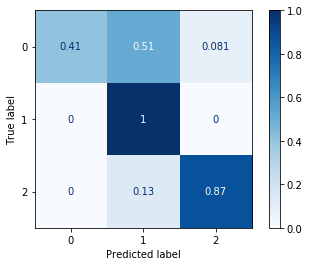

In [13]:
SVC_model.fit(X_train_scaled, np.ravel(y_train))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(SVC_model, X_train_scaled, y_train,
                                 display_labels=[0,1,2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')

score: 0.76


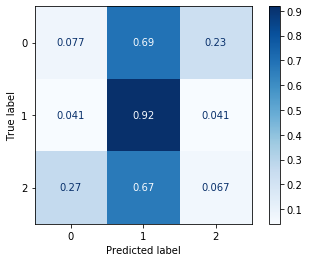

In [18]:
scoreSVM = SVC_model.score(X_test_scaled, y_test)
print('score:', scoreSVM)

plot_confusion_matrix(SVC_model, X_test_scaled, y_test,
                                 display_labels=[0,1,2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
#This shows the issue. the model misclassifies volatile increases in price as potential volitile decreases in price.
#the only resolution for this is to provide additional features that allow the model to distinguish between them

<module 'matplotlib.pyplot' from 'C:\\Users\\avid\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

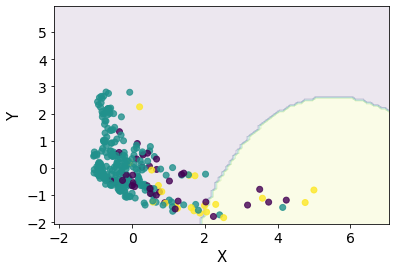

In [17]:
#here we can seet how the model builds a boundry from the training data
plot_decision_boundaries(X_train_scaled, 1,2, y_train, SVC, gamma = .1)

Running SMA over next 5 years and allow prediction to resize bets (aka cancel it is it thinks it will hit risk tolerance)

In [20]:
#new dataset for prediction be careful to insure no information leakage.

start_out_of_sample = datetime(2016,1,1)
end_out_of_sample = datetime(2021,1,1) 
stock_oos = data.DataReader("SPY", 'yahoo', start_out_of_sample, end_out_of_sample).reset_index()
stock_oos.set_index("Date", inplace=True)
vix_oos = data.DataReader("^VIX", 'yahoo', start_out_of_sample, end_out_of_sample).reset_index()
vix_oos.set_index("Date", inplace=True)

In [21]:
oos_df = pd.DataFrame(stock_oos["Volume"]) #data used for SMA function
oos_df["Vix"] = vix_oos["Close"]
oos_df[".4diffclose"] = ts_differencing(stock_oos["Close"],.4,length)
oos_df[".4diffvol"] = ts_differencing(oos_df["Volume"],.4,length)
oos_df[".4diffvix"] = ts_differencing(oos_df["Vix"],.4,length)
oos_df["Close"] = stock_oos["Close"]
oos_df.dropna(inplace=True)
price_data = oos_df["Close"] #need to ensure dates match up with oos_df
oos_df.drop(['Close'], axis=1, inplace=True)
oos_scaled = StandardScale.transform(oos_df)

In [27]:
growth, daily_val, trades, open_dates, close_dates, SMAlist, untouched = SMA(price_data, profit_taking, risk_tolerance, length)
print(price_data[-1]/price_data[0], growth, len(trades), trades.count(2)/len(trades),trades.count(1)/len(trades),trades.count(0)/len(trades))

1.9461766888499323 1.6230867871114734 179 0.0670391061452514 0.8547486033519553 0.0782122905027933


In [26]:
growth, daily_val, trades, open_dates, close_dates, SMAlist = SMA_w_SVCmeta_labeling(price_data, profit_taking, risk_tolerance, length, oos_scaled,SVC_model)
print(price_data[-1]/price_data[0], growth, len(trades), trades.count(2)/len(trades), trades.count(1)/len(trades), trades.count(0)/len(trades))

#The one trade canceled is a trade with a volatile increase in price as we expected from the test data
#potential issue, distribution of profitability changes over time so by 2021 the model being used is 6 years out of date.

1.9461766888499323 1.596720555373349 178 0.06741573033707865 0.8539325842696629 0.07865168539325842
